# Feature Analyses

### Environment

In [5]:
import sys  
sys.path.insert(0, '/home/brunovieira/backup/Tamires_Experiments/Scripts')
import thinning_processing as tp
import thinning_feature_analyses as fa
import pandas as pd

### Data

In [6]:
paths = {
    'data_economo': "/home/brunovieira/backup/Tamires_Experiments/Data/Economo/data_894_economo.parquet",
    'dict_economo': "/home/brunovieira/backup/Tamires_Experiments/Data/Economo/dict_economo.csv",
    'data_dkt': "/home/brunovieira/backup/Tamires_Experiments/Data/DKT/data_894_dkt.parquet", 
    'dict_dkt': "/home/brunovieira/backup/Tamires_Experiments/Data/DKT/dict_dkt.csv",
    'data_bb': "/home/brunovieira/backup/Tamires_Experiments/Data/cytoarchitecture.xlsx"}

df0 = tp.read_database('Economo', paths)
df = tp.build_main_dataframe(df0, tp.reg_polynomial(df0))
df['Global thinning'] = df['Thickness at 10y.o.'] - df['Thickness at 80y.o.'] #jogar isso dentro do tp.build_main_dataframe
df['Global thinning normalized'] = (df['Thickness at 10y.o.'] - df['Thickness at 80y.o.'])/df['Thickness at 10y.o.'] #jogar isso dentro do tp.build_main_dataframe
df = df.rename(columns={'anual_rate':'annual_rate'}) #jogar isso dentro do tp.build_main_dataframe


## 1 - Basic analysis of the variables relation to the annual thining rate
### • What are the features correlation to each other?  

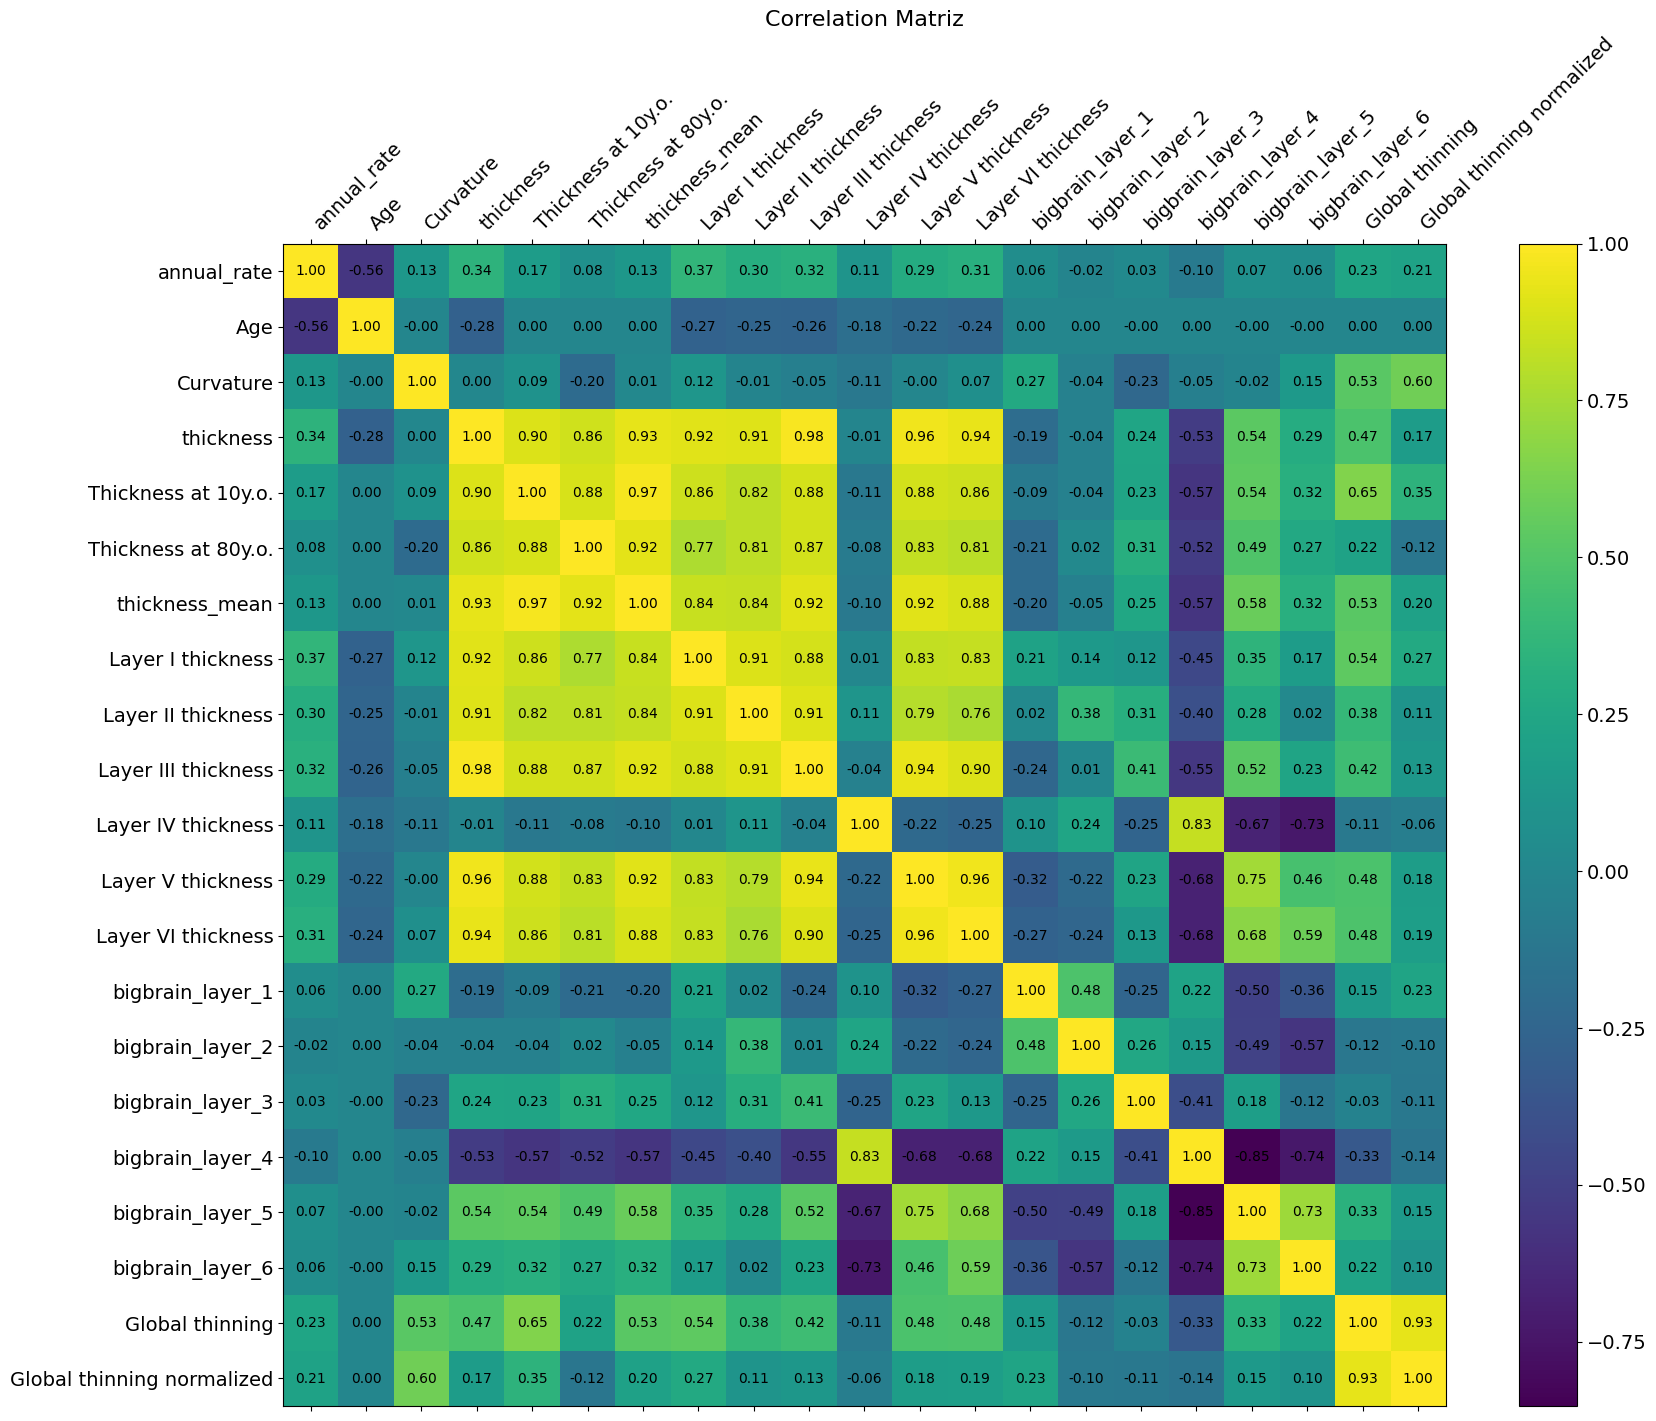

In [8]:
continious_features = ['annual_rate','Age', 'Curvature',
                     'thickness', 'Thickness at 10y.o.', 'Thickness at 80y.o.', 'thickness_mean',  
                     'Layer I thickness','Layer II thickness', 'Layer III thickness', 
                     'Layer IV thickness','Layer V thickness', 'Layer VI thickness',
                     'bigbrain_layer_1', 'bigbrain_layer_2', 'bigbrain_layer_3',
                     'bigbrain_layer_4', 'bigbrain_layer_5', 'bigbrain_layer_6',
                     'Global thinning', 'Global thinning normalized']
fa.corr_matriz(df[continious_features])

### • All the features are important to predict annual thining rate?  

In [9]:
fa.boruta(df.select_dtypes(['number']))

Feature: Age                       Rank: 1,  Support: True
Feature: Hemisphere                Rank: 1,  Support: True
Feature: atlas                     Rank: 1,  Support: True
Feature: area                      Rank: 1,  Support: True
Feature: curv                      Rank: 1,  Support: True
Feature: Curvature                 Rank: 1,  Support: True
Feature: thickness                 Rank: 3,  Support: False
Feature: Gender                    Rank: 6,  Support: False
Feature: handedness                Rank: 7,  Support: False
Feature: ve_1                      Rank: 1,  Support: True
Feature: ve_2                      Rank: 1,  Support: True
Feature: ve_3                      Rank: 1,  Support: True
Feature: ve_4                      Rank: 1,  Support: True
Feature: ve_5                      Rank: 1,  Support: True
Feature: ve_6                      Rank: 1,  Support: True
Feature: bigbrain_layer_1          Rank: 1,  Support: True
Feature: bigbrain_layer_2          Rank: 1,  Support:

## 2 - Thinning segmented by Life Stages
### • Is thinning different in Development, Mid Life and Aging?

temporal_threshold define the three age groups: 
- Development/Pruning < 30
- 30 < MidLife < 60
- Aging/Normal Neurodegeneration > 60

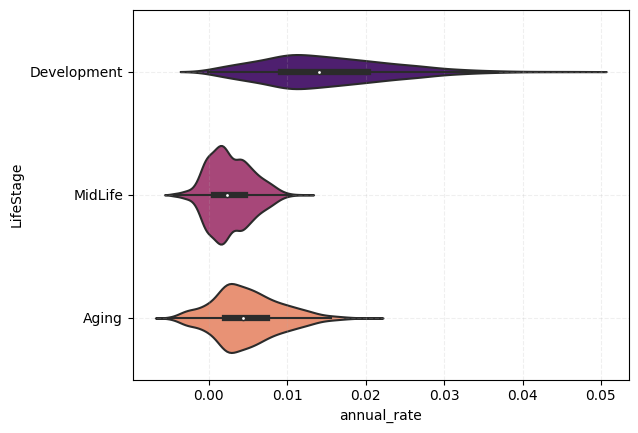

In [10]:
df['LifeStage'] = df.Age.apply(lambda x : fa.life_stages(x, temporal_threshold = [30,60]))
fa.violin_life_stages(df)

### • Does features correlation to thinning vary depending on life stage? Does Life Stages rates and Development Aging Difference have any correlation to each other?
Development Aging Difference is a variable result of the substraction of thinning in evelopment and thinning in aging, both thinning rates are normalized before the operation.

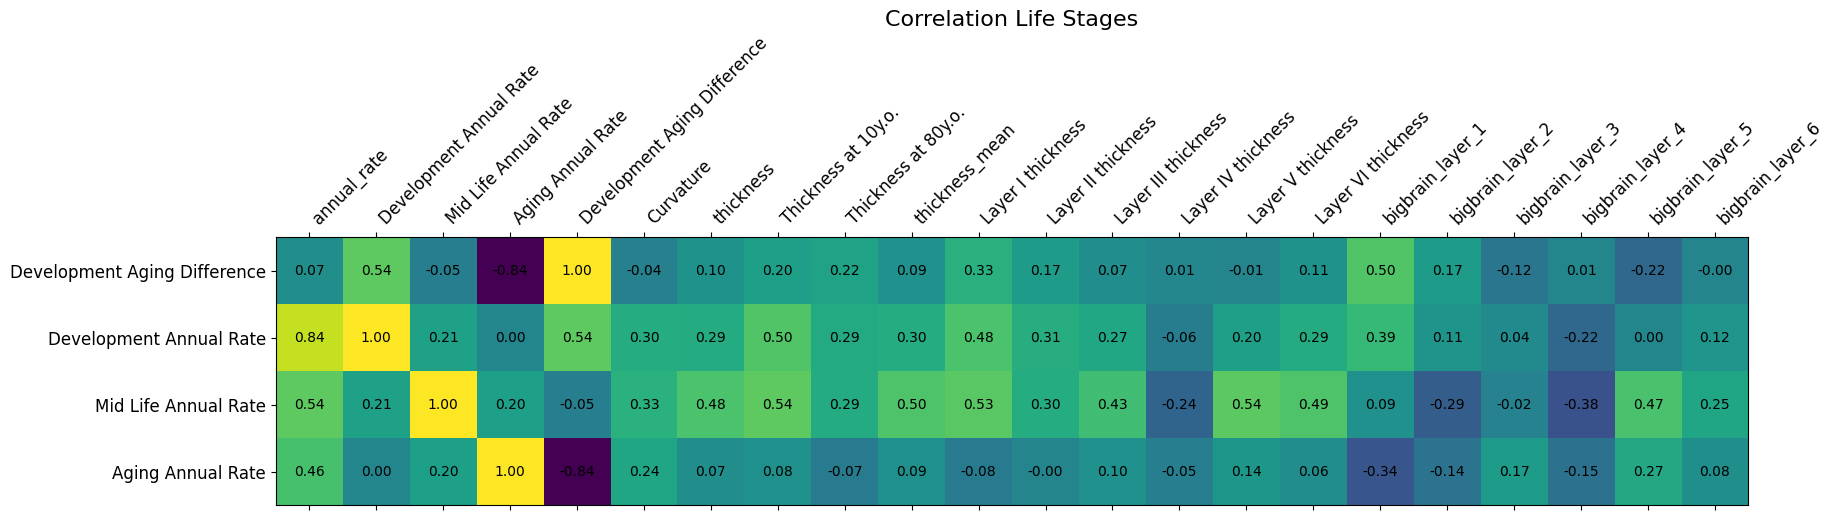

In [11]:
fa.corr_life_stages(df, temporal_threshold = [30,60])

### • The thinning of cortical structures in development can encode the thinning of cortical structures in aging? 

If a structure thin more than average in development, it will thin less than average in aging. If a structure thin on avarage in development, it will remain on avarege in aging. 

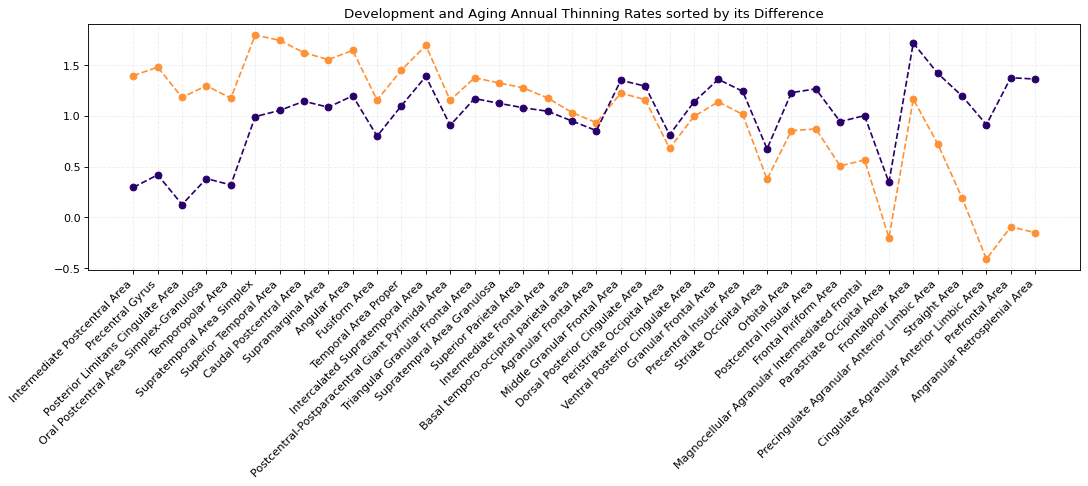

In [12]:
fa.differenceplot(df, temporal_threshold = [30,60])

## 3 - Development and Aging Thinning Difference exploration
### •  We found a high correlation with Layer 1 Percentage. How is the join distribution?

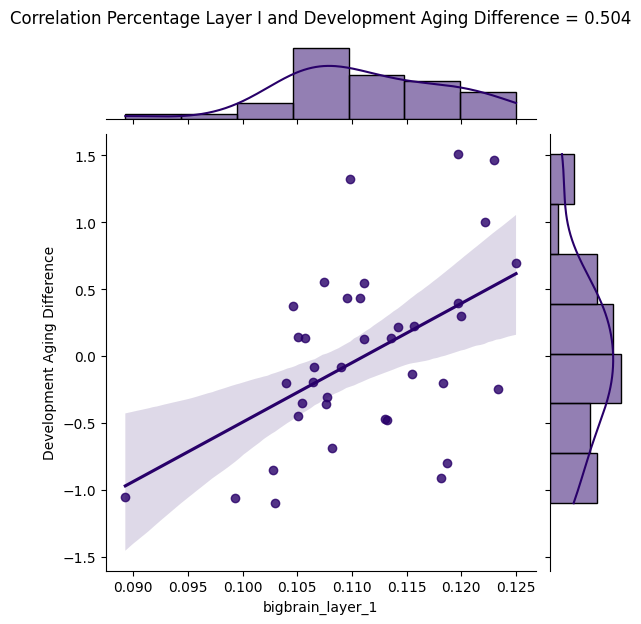

In [13]:
fa.joinplot(df, x="bigbrain_layer_1", temporal_threshold = [30,60])

### • Lets segmentated the Development Aging DIfference in three groups (Neg, Neu, Posi). Layer 1 in each group show statistical significance (ANOVA, Kruskal)?

If a structure thin more than average in development, it will thin less than average in aging. If a structure thin on avarage in development, it will remain on avarege in aging. But how much ossilation can still be considere avarege: what is the avarege interval? Avarege interval it will be call Neutral difference.
- Negative difference (Dif Neg) when comparing thining in development and in aging: < mean - threshod
- Neutral difference (Dif Neu) when comparing thining in development and in aging: mean -/+ threshod
- Positive difference (Dif Posi) when comparing thining in development and in aging: > mean + threshod

In [14]:
df_groups, pkruskal, pf_oneway = fa.find_intervals(df,
                                                x="bigbrain_layer_1",
                                                temporal_threshold = [30,60], spatial_threshold=0.25)
print(pkruskal)
print(pf_oneway)

KruskalResult(statistic=6.912946290777878, pvalue=0.031540805922215406)
F_onewayResult(statistic=4.323456067027723, pvalue=0.0209895970177751)


### •  What are the Layer 1 stats for each group?

In [15]:
df_groups

percentage  bigbrain_layer_1_mean  bigbrain_layer_1_std  \
DifNeg    34.210526               0.107026              0.007908   
DifNeu    34.210526               0.111410              0.005913   
DifPosi   31.578947               0.115234              0.006998   

         bigbrain_layer_1_sem  
DifNeg               0.002193  
DifNeu               0.001640  
DifPosi              0.002020

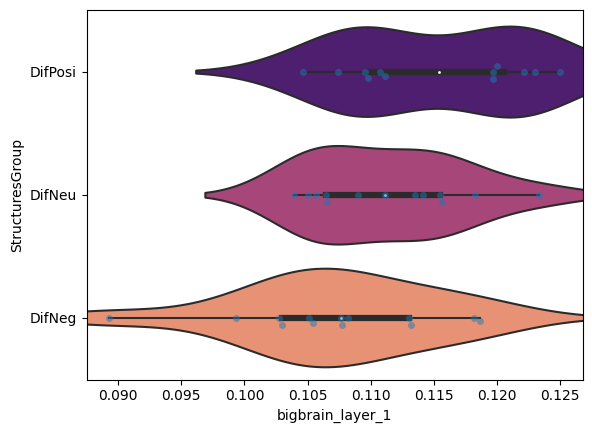

In [16]:
fa.violinplot(df, x="bigbrain_layer_1", temporal_threshold = [30,60], spatial_threshold=0.25)